# Machine Learning
### Mutual information for continuous-continuous case
**Mutual information** (**MI**) measures the amount of information obtained about the target variable $Y$ by observing a feature $X$. Specifically, for two continouous random variables $X$ (feature) and $Y$ (target), the mutual information is defined as:
<br>$\large I(X;Y)=\int\int_{\mathcal{S_{XY}}} p(x,y)\cdot log(\frac{p(x,y)}{p(x)\cdot p(y)})\,dx\,dy$
<br>Where
- $p(x,y)$: joint pdf (probablity density function)  
- $p(x),p(y)$: marginal pdfs  
- $\mathcal{S_{XY}}=\{(x.y)\in R^2 | p(x,y)>0\}$  is the **joint support**.
- Unit: nats (if natural log) or bits (if log₂)


<hr>

In the following, we estimate joint probability and marginal probabilites of each pair of data points by KDE_2D and KDE_1D, respectively. By which, we compute the **mutual information** using the **Monte Carlo estimation** of expectation, which was mentioned in an earlier post. Finally, we use the Python code with some examples. 
<br> **Bonus:** An example in **time series analysis** is also given in which we detect the correct lag.

<hr>

**Hint:** It should be mentioned that in the code, we have an option to **normalize** the data points or not. If we use bandwidth selection rules such as Scott's rule, which is proportional to the standard deviation of data points, the normalization step becomes unnecessary. Otherwise, we should use normalizaiton before computing mutual informaiton.

<hr>

https://github.com/ostad-ai/Machine-Learning
<br> Explanation: https://www.pinterest.com/HamedShahHosseini/Machine-Learning/

In [1]:
# Import required modules
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mi_kde(X, Y, normalize=False):
    """
    A KDE-based MI computation with Gaussian kernel
    and Scott's bandwidth rule
    
    normalize=True is only needed for:
    1. Fixed bandwidths
    2. Numerical stability
    """
    epsilon = 1e-10
    X = np.asarray(X).flatten()
    Y = np.asarray(Y).flatten()
    n = len(X)
    
    if normalize:
        X = (X - np.mean(X)) / np.std(X)
        Y = (Y - np.mean(Y)) / np.std(Y)
    
    # PROPER bandwidths
    # For 1D KDE (marginals): Scott's rule h = sigma * n^(-1/5)
    hx_1d = np.std(X) * n**(-1/5)
    hy_1d = np.std(Y) * n**(-1/5)
    
    # For 2D KDE (joint, product kernel): h = sigma * n^(-1/6)
    hx_2d = np.std(X) * n**(-1/6)
    hy_2d = np.std(Y) * n**(-1/6)
    
    # Precompute for efficiency
    mi_sum = 0
    valid = 0
    
    # Sample points for Monte Carlo
    indices = np.random.choice(n, min(n, 1000), replace=False)
    
    for i in indices:
        xi, yi = X[i], Y[i]
        
        # For marginal px (using 1D bandwidth)
        u_px = (xi - X) / hx_1d
        Kx_px = np.exp(-0.5 * u_px**2)
        px = np.sum(Kx_px) / (n * hx_1d * np.sqrt(2*np.pi))
        
        # For marginal py (using 1D bandwidth)
        v_py = (yi - Y) / hy_1d
        Ky_py = np.exp(-0.5 * v_py**2)
        py = np.sum(Ky_py) / (n * hy_1d * np.sqrt(2*np.pi))
        
        # For joint pxy (using 2D bandwidths)
        u_pxy = (xi - X) / hx_2d
        v_pxy = (yi - Y) / hy_2d
        Kx_pxy = np.exp(-0.5 * u_pxy**2)
        Ky_pxy = np.exp(-0.5 * v_pxy**2)
        pxy = np.sum(Kx_pxy * Ky_pxy) / (n * hx_2d * hy_2d * 2*np.pi)
        
        if pxy > epsilon and px > epsilon and py > epsilon:
            mi_sum += np.log(pxy / (px * py))
            valid += 1
    
    return max(mi_sum / valid, 0) if valid > 0 else 0

In [3]:
# Test MI computation with KDE
n = 1000
Z = np.random.randn(n)

# Same relationship, different scales
X1 = Z + 0.2*np.random.randn(n)
Y1 = Z + 0.2*np.random.randn(n)

X2 = X1 * 1000  # Scale X
Y2 = Y1 * 0.001  # Scale Y differently

print("=== Testing MI computation with KDE ===")
print(f"Without normalization:")
print(f"  (X1,Y1): MI = {mi_kde(X1, Y1, normalize=False):.4f}")
print(f"  (X2,Y2): MI = {mi_kde(X2, Y2, normalize=False):.4f}")
print()
print(f"With normalization:")
print(f"  (X1,Y1): MI = {mi_kde(X1, Y1, normalize=True):.4f}")
print(f"  (X2,Y2): MI = {mi_kde(X2, Y2, normalize=True):.4f}")

=== Testing MI computation with KDE ===
Without normalization:
  (X1,Y1): MI = 0.9883
  (X2,Y2): MI = 0.9883

With normalization:
  (X1,Y1): MI = 0.9883
  (X2,Y2): MI = 0.9883


In [4]:
# Example: Testing statistical dependence

# Generate synthetic data
n_samples = 1000

# 1. Strong linear relationship
X_lin = np.random.randn(n_samples)
Y_lin = 2 * X_lin + np.random.randn(n_samples) * 0.1  # Small noise

# 2. Nonlinear relationship (quadratic)
X_quad = np.random.uniform(-2, 2, n_samples)
Y_quad = X_quad**2 + np.random.randn(n_samples) * 0.2

# 3. Circular relationship
theta = np.random.uniform(0, 2*np.pi, n_samples)
r = 1 + np.random.randn(n_samples) * 0.1
X_circ = r * np.cos(theta)
Y_circ = r * np.sin(theta)

# 4. Independent variables
X_indep = np.random.randn(n_samples)
Y_indep = np.random.randn(n_samples)

# Compute MI for each case
mi_linear = mi_kde(X_lin, Y_lin)
mi_quadratic = mi_kde(X_quad, Y_quad)
mi_circular = mi_kde(X_circ, Y_circ)
mi_independent = mi_kde(X_indep, Y_indep)

print("Mutual Information Results:")
print(f"Linear relationship: {mi_linear:.4f} nats")
print(f"Quadratic relationship: {mi_quadratic:.4f} nats")
print(f"Circular relationship: {mi_circular:.4f} nats")
print(f"Independent variables: {mi_independent:.4f} nats")

Mutual Information Results:
Linear relationship: 1.2889 nats
Quadratic relationship: 0.7076 nats
Circular relationship: 0.3259 nats
Independent variables: 0.0260 nats


In [5]:
# Another example for checking dependence
# Generate synthetic time series
n_points = 500
t = np.linspace(0, 10, n_points)

# Signal 1: Sine wave
signal1 = np.sin(2 * np.pi * 1 * t)  # 1 Hz

# Signal 2: Delayed version (with some noise)
delay = 20  # samples
signal2 = np.sin(2 * np.pi * 1 * (t - t[delay])) + np.random.randn(n_points) * 0.1

# Signal 3: Unrelated random signal
signal3 = np.random.randn(n_points)

# Compute MI between different time series
print("Time Series Mutual Information:")
print(f"Signal1 vs Signal2 (delayed): {mi_kde(signal1, signal2, normalize=True):.4f}")
print(f"Signal1 vs Signal3 (unrelated): {mi_kde(signal1, signal3, normalize=True):.4f}")

Time Series Mutual Information:
Signal1 vs Signal2 (delayed): 0.4470
Signal1 vs Signal3 (unrelated): 0.0000


<hr style="background:lightgreen; height:3px">

# Bonus
#### Time Series Analysis with  Lag Detection

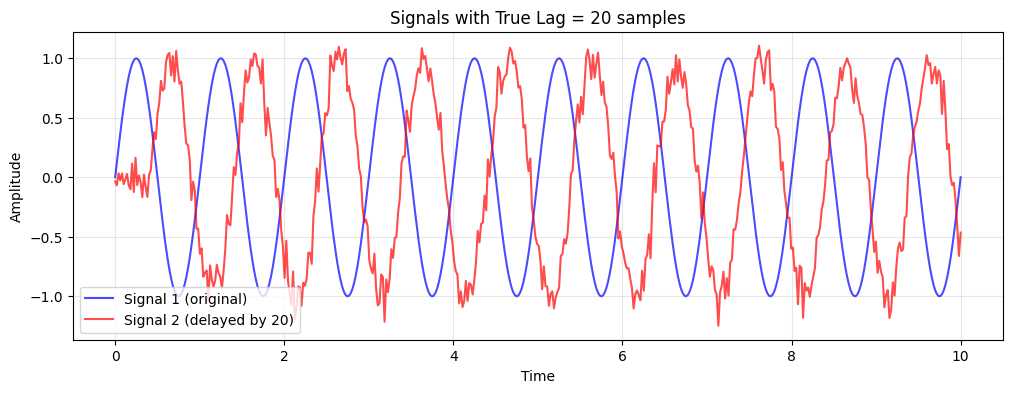

True lag: 20
Detected optimal lag: 20
Maximum MI at this lag: 0.9355


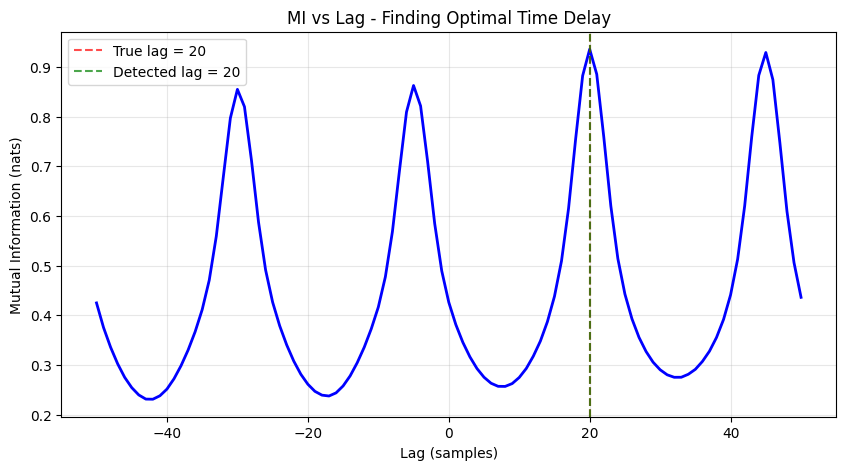

In [6]:
def compute_mi_with_lag(x, y, lag, normalize=True):
    """
    Correctly compute MI between x(t) and y(t+lag)
    
    If lag > 0: x leads y (x(t) vs y(t+lag))
    If lag < 0: y leads x (x(t+|lag|) vs y(t))
    """
    n = len(x)
    
    if lag >= 0:
        # x leads y by 'lag' samples
        x_trimmed = x[:n-lag]
        y_trimmed = y[lag:]
    else:
        # y leads x by |lag| samples
        x_trimmed = x[-lag:]  # positive lag value
        y_trimmed = y[:n+lag]  # lag is negative
    
    return mi_kde(x_trimmed, y_trimmed, normalize)

# Generate proper test data with true lag = 20
n_samples = 500
t = np.linspace(0, 10, n_samples)

# Signal 1: Base signal
signal1 = np.sin(2 * np.pi * 1 * t)  # 1 Hz

# Signal 2: Delayed version with TRUE LAG = 20
true_lag = 20
signal2 = np.zeros_like(signal1)
signal2[true_lag:] = signal1[:-true_lag]  # Proper delay
signal2 += np.random.randn(n_samples) * 0.1  # Add noise

# Plot the signals
plt.figure(figsize=(12, 4))
plt.plot(t, signal1, 'b-', alpha=0.7, label='Signal 1 (original)')
plt.plot(t, signal2, 'r-', alpha=0.7, label='Signal 2 (delayed by 20)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'Signals with True Lag = {true_lag} samples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Test different lags
max_lag = 50
lags = np.arange(-max_lag, max_lag + 1)
mi_values = np.zeros(len(lags))

for i, lag in enumerate(lags):
    mi_values[i] = compute_mi_with_lag(signal1, signal2, lag, normalize=True)

# Find lag with maximum MI
optimal_lag_idx = np.argmax(mi_values)
optimal_lag = lags[optimal_lag_idx]
max_mi = mi_values[optimal_lag_idx]

print(f"True lag: {true_lag}")
print(f"Detected optimal lag: {optimal_lag}")
print(f"Maximum MI at this lag: {max_mi:.4f}")

# Plot MI vs lag
plt.figure(figsize=(10, 5))
plt.plot(lags, mi_values, 'b-', linewidth=2)
plt.axvline(x=true_lag, color='r', linestyle='--', alpha=0.7, label=f'True lag = {true_lag}')
plt.axvline(x=optimal_lag, color='g', linestyle='--', alpha=0.7, label=f'Detected lag = {optimal_lag}')
plt.xlabel('Lag (samples)')
plt.ylabel('Mutual Information (nats)')
plt.title('MI vs Lag - Finding Optimal Time Delay')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()